# Laboratory Work 2 (var 2)

Multiclass Classification with CNN and RNN

In [ ]:
!pip install pymorphy3 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 11.1 MB/s eta 0:00:00


In [ ]:
# @title Imports {display-mode: "form"}

import math
import re
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from google.colab import drive
from pymystem3.mystem import Mystem
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers, callbacks
from tqdm.notebook import tqdm

In [ ]:
# @title Env Preparation {display-mode: "form"}

pd.options.mode.chained_assignment = None
tqdm.pandas()

## Load Dataset

In [ ]:
# @title Подключение диска {display-mode: "form"}

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/data/var2.zip -d /content

Archive:  /content/drive/MyDrive/data/var2.zip
  inflating: /content/lyrics.csv     


In [ ]:
df = pd.read_csv('lyrics.csv')
df

,Unnamed: 0,year,tag,lyrics,title
0,14072,2009,pop,[Куплет 1]\nТолько степь вздохнёт едва\nКак Бо...,Степь Step
1,22982,2001,rap,"[Текст песни ""Direct""]\n\n[Интро]\n*Stop been ...",Gang Bangin Shit
2,49151,2006,rap,[Текст песни «Будущие мамы»]\n\n[Припев]\nБуду...,Будущие мамы Expectant Moms
3,50914,2011,rap,Зимнее Утро\n\nКуплет 1\n\nЗимнее утро будильн...,Zimnee Utro - Зимнее Утро
4,79951,2011,rap,[Текст песни «Жук в муравейнике» ft. Schokk]\n...,Жук в муравейнике Beetle in an anthill
...,...,...,...,...,...
158967,5134804,2022,rock,[Текст песни «Силуэт»]\n\n[Куплет 1: потери.]\...,Силуэт A shadow
158968,5134820,2021,pop,Я не могу найти Милкис с дорой\nКупи пожалуйст...,Милкис с Дорой
158969,5134830,2022,rap,[Текст песни «На завод!»]\n\n[Интро]\nМутный м...,На завод to factory
158970,5134833,2022,rap,Интро\n\nEvil empire –\nLaughing all the way t...,Dont STOP


In [ ]:
df.drop(columns=['Unnamed: 0', 'year', 'title'], inplace=True, errors='ignore')
df.head()

,tag,lyrics
0,pop,[Куплет 1]\nТолько степь вздохнёт едва\nКак Бо...
1,rap,"[Текст песни ""Direct""]\n\n[Интро]\n*Stop been ..."
2,rap,[Текст песни «Будущие мамы»]\n\n[Припев]\nБуду...
3,rap,Зимнее Утро\n\nКуплет 1\n\nЗимнее утро будильн...
4,rap,[Текст песни «Жук в муравейнике» ft. Schokk]\n...


## EDA

### Overview

Проверим, присутствуют ли в датасете пустые ячейки и строки длиной 0

In [ ]:
df.replace('', np.nan, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158972 entries, 0 to 158971
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   tag     158972 non-null  object
 1   lyrics  158972 non-null  object
dtypes: object(2)
memory usage: 2.4+ MB


В датасете отсутствуют пустые строки

In [ ]:
df.describe()

,tag,lyrics
count,158972,158972
unique,3,158484
top,rap,"Данная оболочка создана для того, чтобы систем..."
freq,108904,17


Наблюдения:
1. Тексты поделены на 3 класса, будем решать задачу многоклассовой классификации
2. Самый частотный тэг -- rap с частотой 108_904. Учитывая то, что в датасете всего 158_972 текста, очевидно, что датасет несбалансирован
3. В текстах присутствуют дубликаты. Можно сразу избавиться от них, хотя после предобработки датасета нужно будет снова их дропнуть

In [ ]:
df.drop_duplicates(subset='lyrics', inplace=True, ignore_index=True)
df

,tag,lyrics
0,pop,[Куплет 1]\nТолько степь вздохнёт едва\nКак Бо...
1,rap,"[Текст песни ""Direct""]\n\n[Интро]\n*Stop been ..."
2,rap,[Текст песни «Будущие мамы»]\n\n[Припев]\nБуду...
3,rap,Зимнее Утро\n\nКуплет 1\n\nЗимнее утро будильн...
4,rap,[Текст песни «Жук в муравейнике» ft. Schokk]\n...
...,...,...
158479,rock,[Текст песни «Силуэт»]\n\n[Куплет 1: потери.]\...
158480,pop,Я не могу найти Милкис с дорой\nКупи пожалуйст...
158481,rap,[Текст песни «На завод!»]\n\n[Интро]\nМутный м...
158482,rap,Интро\n\nEvil empire –\nLaughing all the way t...


Из выведенных примеров видим пару вещей:
* Во-первых, тексты песен содержат своего рода мета-информацию о структурных частях песен. Стоит проверить их количество и разнообразие, потому как они могут дать информацию о жанрах песен.
* Во-вторых, некоторые песни содержат слова на английском языке. Есть смысл посмотреть на распределение англоязычных слов по текстам, потому что может оказаться, что они характерны только для рэп-композиций.

### Working with texts info

In [ ]:
df_with_meta = df.loc[df['lyrics'].str.contains(r'\[.+\]')]
df_with_meta.shape

(122955, 2)

Как видим, мета-информация содержится в 122_955 текстах из 158_484. Соответственно, просто заменять все одним плейсхолдером не имеет особого смысла.

Подсчитаем, сколько раз встречаются те или иные мета-данные

In [ ]:
meta_pattern = re.compile(r'\[.+\]')
meta_counter = Counter()
for row in df_with_meta.iterrows():
  meta_counter.update(meta_pattern.findall(row[1]['lyrics']))

len(list(meta_counter))

137862

Большое разнообразие. Выведем несколько наиболее и наименее частотных элементов

In [ ]:
meta_counter.most_common(10)

[('[Припев]', 139573),
 ('[Куплет 1]', 44656),
 ('[Куплет 2]', 42758),
 ('[Куплет]', 30188),
 ('[Интро]', 23722),
 ('[Бридж]', 19339),
 ('[Аутро]', 18190),
 ('[?]', 16021),
 ('[Куплет 3]', 8383),
 ('[Hook]', 7900)]

In [ ]:
meta_counter.most_common()[:-11:-1]

[('[Текст песни «На завод!»]', 1),
 ('[Куплет 2: фрэнк?]', 1),
 ('[Куплет 1: потери.]', 1),
 ('[1 Куплет: Knxten]', 1),
 ('[Текст песни "So Icy Vamp K"]', 1),
 ('[Текст песни «08:00 утра»]', 1),
 ('[Текст песни «Сваи»]', 1),
 ('[Куплет (ASHRAFOV)]', 1),
 ('[Куплет (LERDOS)]', 1),
 ('[Текст песни «Drugdealer»]', 1)]

Также рассмотрим средние значения

In [ ]:
meta_counter.most_common()[60_000:60_011:]

[('[Куплет 6: Хайтайм]', 1),
 ('[Текст песни "Шашлычки"]', 1),
 ('[Текст песни «Як 2»]', 1),
 ('[Текст песни «Колёса»]', 1),
 ('[Loqiemean | In Person]', 1),
 ('[Текст песни «Инструкция памяти»]', 1),
 ('[Текст песни «Девочка снова на трапе*»]', 1),
 ('[Verse 2: Ваня Светло]', 1),
 ('[Verse 3: МЦ Джиглипуф]', 1),
 ('[Verse 4: Бабачёк]', 1),
 ('[Текст песни «Надвое вены»]', 1)]

Этой информации явно не хватает однообразия

Возможно, если смотреть только на первое слово, то это даст более полезную информацию

In [ ]:
meta_pattern = re.compile(r'\[\w+')
meta_counter = Counter()
for row in df_with_meta.iterrows():
  meta_counter.update(meta_pattern.findall(row[1]['lyrics']))

len(list(meta_counter))

6671

Стао гораздо лучше. Снова посмотрим, что у нас собралось

In [ ]:
meta_counter.most_common(10)

[('[Припев', 191891),
 ('[Куплет', 187318),
 ('[Текст', 69369),
 ('[Интро', 31806),
 ('[Бридж', 26280),
 ('[Аутро', 23485),
 ('[Verse', 18115),
 ('[Hook', 11779),
 ('[Предприпев', 8640),
 ('[Chorus', 8365)]

In [ ]:
meta_counter.most_common()[:-11:-1]

[('[Scatias', 1),
 ('[Куплем', 1),
 ('[Развитие', 1),
 ('[moneycash', 1),
 ('[Virtual', 1),
 ('[YNW', 1),
 ('[Stacy', 1),
 ('[HYPERPOP', 1),
 ('[Будет', 1),
 ('[Акаманах', 1)]

Есть ощущение, что тут есть как такие варианты, которые не дадут никакой информации, поскольку они встречаются в слишком многом или, наоборот, в слишком малом количестве песен, как и такие, которые действительно могут дать какую-то полезную информацию.

In [ ]:
in_rap = round(len(df_with_meta.loc[(df_with_meta['tag'] == 'rap') & (df_with_meta['lyrics'].str.contains(r'\[припев', flags=re.IGNORECASE))]) / len(df_with_meta.loc[df_with_meta['tag'] == 'rap']), 2)
in_pop = round(len(df_with_meta.loc[(df_with_meta['tag'] == 'pop') & (df_with_meta['lyrics'].str.contains(r'\[припев', flags=re.IGNORECASE))]) / len(df_with_meta.loc[df_with_meta['tag'] == 'pop']), 2)
in_rock = round(len(df_with_meta.loc[(df_with_meta['tag'] == 'rock') & (df_with_meta['lyrics'].str.contains(r'\[припев', flags=re.IGNORECASE))]) / len(df_with_meta.loc[df_with_meta['tag'] == 'rock']), 2)

print(f'''ПРИПЕВ:
in rap: {in_rap}
in pop: {in_pop}
in_rock: {in_rock}''')

ПРИПЕВ:
in rap: 0.68
in pop: 0.75
in_rock: 0.75


Мета о припеве встречается слишком часто во всех классах. Проверим менее частотные варианты.

In [ ]:
in_rap = round(len(df_with_meta.loc[(df_with_meta['tag'] == 'rap') & (df_with_meta['lyrics'].str.contains(r'\[Бридж', flags=re.IGNORECASE))]) / len(df_with_meta.loc[df_with_meta['tag'] == 'rap']), 2)
in_pop = round(len(df_with_meta.loc[(df_with_meta['tag'] == 'pop') & (df_with_meta['lyrics'].str.contains(r'\[Бридж', flags=re.IGNORECASE))]) / len(df_with_meta.loc[df_with_meta['tag'] == 'pop']), 2)
in_rock = round(len(df_with_meta.loc[(df_with_meta['tag'] == 'rock') & (df_with_meta['lyrics'].str.contains(r'\[Бридж', flags=re.IGNORECASE))]) / len(df_with_meta.loc[df_with_meta['tag'] == 'rock']), 2)

print(f'''БРИДЖ:
in rap: {in_rap}
in pop: {in_pop}
in_rock: {in_rock}''')

БРИДЖ:
in rap: 0.16
in pop: 0.19
in_rock: 0.19


Эта информация уже встречается слишком редко, и в примерно равной степени для всех тэгов.

In [ ]:
in_rap = round(len(df_with_meta.loc[(df_with_meta['tag'] == 'rap') & (df_with_meta['lyrics'].str.contains(r'\[Текст', flags=re.IGNORECASE))]) / len(df_with_meta.loc[df_with_meta['tag'] == 'rap']), 2)
in_pop = round(len(df_with_meta.loc[(df_with_meta['tag'] == 'pop') & (df_with_meta['lyrics'].str.contains(r'\[Текст', flags=re.IGNORECASE))]) / len(df_with_meta.loc[df_with_meta['tag'] == 'pop']), 2)
in_rock = round(len(df_with_meta.loc[(df_with_meta['tag'] == 'rock') & (df_with_meta['lyrics'].str.contains(r'\[Текст', flags=re.IGNORECASE))]) / len(df_with_meta.loc[df_with_meta['tag'] == 'rock']), 2)

print(f'''ТЕКСТ
in rap: {in_rap}
in pop: {in_pop}
in_rock: {in_rock}''')

ТЕКСТ
in rap: 0.51
in pop: 0.67
in_rock: 0.7


In [ ]:
in_rap = round(len(df_with_meta.loc[(df_with_meta['tag'] == 'rap') & (df_with_meta['lyrics'].str.contains(r'\[Интро', flags=re.IGNORECASE))]) / len(df_with_meta.loc[df_with_meta['tag'] == 'rap']), 2)
in_pop = round(len(df_with_meta.loc[(df_with_meta['tag'] == 'pop') & (df_with_meta['lyrics'].str.contains(r'\[Интро', flags=re.IGNORECASE))]) / len(df_with_meta.loc[df_with_meta['tag'] == 'pop']), 2)
in_rock = round(len(df_with_meta.loc[(df_with_meta['tag'] == 'rock') & (df_with_meta['lyrics'].str.contains(r'\[Интро', flags=re.IGNORECASE))]) / len(df_with_meta.loc[df_with_meta['tag'] == 'rock']), 2)

print(f'''ИНТРО
in rap: {in_rap}
in pop: {in_pop}
in_rock: {in_rock}''')

ИНТРО
in rap: 0.31
in pop: 0.17
in_rock: 0.11


Рассмотрев разные варианты, я делаю вывод, что мета-информацию проще будет удалить, потому как она, по-видимому, не даст нам дополнительной информации о жанре песен

### Working with english texts

In [ ]:
in_rap = round(len(df_with_meta.loc[(df_with_meta['tag'] == 'rap') & (df_with_meta['lyrics'].str.contains(r'[a-z]', flags=re.IGNORECASE))]) / len(df_with_meta.loc[df_with_meta['tag'] == 'rap']), 2)
in_pop = round(len(df_with_meta.loc[(df_with_meta['tag'] == 'pop') & (df_with_meta['lyrics'].str.contains(r'[a-z]', flags=re.IGNORECASE))]) / len(df_with_meta.loc[df_with_meta['tag'] == 'pop']), 2)
in_rock = round(len(df_with_meta.loc[(df_with_meta['tag'] == 'rock') & (df_with_meta['lyrics'].str.contains(r'[a-z]', flags=re.IGNORECASE))]) / len(df_with_meta.loc[df_with_meta['tag'] == 'rock']), 2)

print(f'''English лангуадже
in rap: {in_rap}
in pop: {in_pop}
in_rock: {in_rock}''')

English лангуадже
in rap: 0.79
in pop: 0.42
in_rock: 0.27


С англоязычными словами ситуация интереснее. Кажется, английский чаще всего встречается в рэпе, в то время как в (видимо, русском) роке к его применению прибегают редко. Однако, здесь мы не учитываем, находится английский текст в мета-информации или вне её. Есть смысл дополнительно проверить распределение англоязычных слов ещё раз после удаления меты.

### Labels Distribution

In [ ]:
df['tag'].value_counts()

rap     108654
pop      30603
rock     19227
Name: tag, dtype: int64

Наблюдается сильный дисбаланс классов в сторону рэпа.

## Preprocessing

Лемматизация проводится батчами с применением программы MyStem. При этом было принято решение не отбрасывать стоп-слова, поскольку они могут дать полезную информацию для данного типа текстов.

In [ ]:
def del_meta(text: str) -> str:
  return re.sub(r'\[.+\]', '', text)


def clear(text: str) -> list:
  return ' '.join(re.findall('\w+', text.lower()))


def replace_eng(text: str) -> str:
  return re.sub('[a-z]+', 'ENG', text, flags=re.I)

'''def lemmatize(tokens: list) -> str:
  morph = MorphAnalyzer()
  return ' '.join([morph.parse(token)[0].normal_form for token in tokens])'''

def lemmatize_mystem(texts: pd.Series, lemmatizer) -> str:
  batch_size = 1000
  batch_n = 0
  lemmatized_texts = []
  while batch_n < math.ceil(len(df) / batch_size):
    batch_n += 1
    batch = texts[batch_size * (batch_n - 1):batch_size * batch_n]
    lemmatized_texts.extend(''.join(lemmatizer.lemmatize(' DELIMETER '.join(batch))).split(' DELIMETER '))
    print(f'texts lemmatized: {batch_size * batch_n} out of {len(df)}')
  return lemmatized_texts

def preprocess(text: str) -> str:
  return replace_eng(del_meta(text))

Англоязычные слова заменяются плейсхолдером.

In [ ]:
df['lyrics'] = df['lyrics'].progress_apply(preprocess)
df.head()

  0%|          | 0/158484 [00:00<?, ?it/s]

,tag,lyrics
0,pop,\nТолько степь вздохнёт едва\nКак Божию росой ...
1,rap,"\n\n\n*ENG ENG ENG ENG' ENG*\nЕ, ENG ENG'ENG E..."
2,rap,"\n\n\nБудущие мамы, хвастайте телами\nПарни, н..."
3,rap,Зимнее Утро\n\nКуплет 1\n\nЗимнее утро будильн...
4,rap,"\n\n\nЯ помню в детстве миг, как девственник\n..."


In [ ]:
mystem = Mystem()
lemmatized_texts = lemmatize_mystem(df['lyrics'], mystem)
len(lemmatized_texts)

In [ ]:
lemmatized_texts[:2]

['\nтолько степь вздыхать едва\nкак божий роса трава\nомывать нога в стремя\nочнуться река время\n\n\nсмотреть: нестись конница\nстепной вольница\nполк суровый казак\nиз тьма век\n\n\nночь молить останавливаться\nмесяц брить скула-лицо\nвиться над папаха чуб\nхлестать ус, сверкать зуб\n\n\nстепь шальной войско мчать\nворон гибельный кричать\nлететь, рисковать голова, казак лихой!\n\nмать-отец рыдать оставлять\nнавсегда постель заправлять\nк сердце - горсть земля родимый\nда взасос - уста любимый\n\n\nс правда-матка под уздцы\nуезжать молодец\nотведывать желчь полынный-\nсудьба фамильный...\nи степь шальной войско мчать\nворон гибельный кричать\nлететь, рисковать голова, казак лихой!\n\n\nконь ржать, котел бурлиться\nдым от трубочка клубиться\nкаша-брага-песня-пляс\nи зыбкий в предрассветный час\n\n\nой, казак, гулять пока\nдавать поспать свой враг\nно в поле дикий есаул\nопять звать в заря\nи вновь нестись конница\nстепной вольница\nлететь, рисковать голова, казак лихой!\nтам степь шал

In [ ]:
df['lyrics'] = lemmatized_texts
df.head()

,tag,lyrics
0,pop,\nтолько степь вздыхать едва\nкак божий роса т...
1,rap,"\n\n\n*ENG ENG ENG ENG' ENG*\nе, ENG ENG'ENG E..."
2,rap,"\n\n\nбудущий мама, хвастать тело\nпарень, не ..."
3,rap,зимний утро\n\nкуплет 1\n\nзимний утро будильн...
4,rap,"\n\n\nя помнить в детство миг, как девственник..."


In [ ]:
df['lyrics'] = df['lyrics'].progress_apply(clear)
df.head(2)

  0%|          | 0/158484 [00:00<?, ?it/s]

,tag,lyrics
0,pop,только степь вздыхать едва как божий роса трав...
1,rap,eng eng eng eng eng е eng eng eng eng eng eng ...


О, это же Эминем

### Check for Eng labels again

In [ ]:
in_rap = round(len(df.loc[(df['tag'] == 'rap') & (df['lyrics'].str.contains('eng'))]) / len(df.loc[df['tag'] == 'rap']), 2)
in_pop = round(len(df[(df['tag'] == 'pop') & (df['lyrics'].str.contains('eng'))]) / len(df.loc[df['tag'] == 'pop']), 2)
in_rock = round(len(df.loc[(df['tag'] == 'rock') & (df['lyrics'].str.contains('eng'))]) / len(df.loc[df['tag'] == 'rock']), 2)

print(f'''English лангуадже
in rap: {in_rap}
in pop: {in_pop}
in_rock: {in_rock}''')

English лангуадже
in rap: 0.67
in pop: 0.26
in_rock: 0.16


Исходя из информации о распределении англоязычных слов, имеет смысл оставить плейсхолдеры

### Checkpoint

In [ ]:
# SAVE
df.to_csv('/content/drive/MyDrive/data/preprocessed.csv')

In [ ]:
# LOAD
df = pd.read_csv('/content/drive/MyDrive/data/preprocessed.csv').drop(columns=['Unnamed: 0'])
df.head()

,tag,lyrics
0,pop,только степь вздыхать едва как божий роса трав...
1,rap,eng eng eng eng eng е eng eng eng eng eng eng ...
2,rap,будущий мама хвастать тело парень не бояться о...
3,rap,зимний утро куплет 1 зимний утро будильник шес...
4,rap,я помнить в детство миг как девственник занима...


In [ ]:
df['lyrics'].duplicated().sum()

964

После предобработки датасета появились новые дубликаты. Удалим их

In [ ]:
df.drop_duplicates(subset='lyrics', inplace=True, ignore_index=True)
df

,tag,lyrics
0,pop,только степь вздыхать едва как божий роса трав...
1,rap,eng eng eng eng eng е eng eng eng eng eng eng ...
2,rap,будущий мама хвастать тело парень не бояться о...
3,rap,зимний утро куплет 1 зимний утро будильник шес...
4,rap,я помнить в детство миг как девственник занима...
...,...,...
157515,rock,сколько история весь жизнь на повтор вернуться...
157516,pop,я не мочь находить милкис с дорыть купить пожа...
157517,rap,мутный мрак eng камоловский синдикат eng на то...
157518,rap,интро eng eng eng eng eng eng eng eng eng eng ...


## Vectorization

Пришло время векторизовать тексты, но для начала надо выбрать, какой длины будут наши векторы. Для этого смотрим на распределение длин токенизированных текстов

### Check Lengths

  0%|          | 0/157520 [00:00<?, ?it/s]

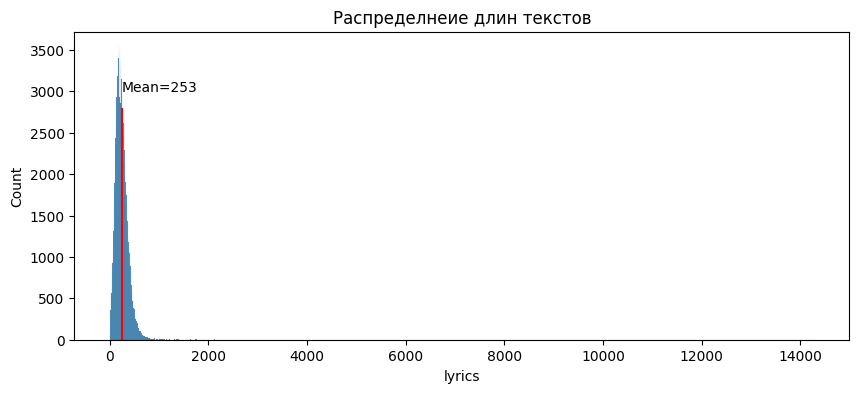

In [ ]:
text_lengths = df['lyrics'].progress_apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 4))
sns.histplot(text_lengths)
plt.title('Распределнеие длин текстов')
plt.axvline(x=np.mean(text_lengths), ymin=0, ymax=0.75, color='r')
plt.text(np.mean(text_lengths), 3000, f'Mean={int(np.mean(text_lengths))}')
plt.show()

У нас определённо есть исключения -- очень длинные тексты, но не думаю, что это проблема. Сделаем вектора размерностью 250.

Для векторизации было принято решение использовать `TextVectrization` из библиотеки `Keras`. Однако его необходимо обучать на тренировочной выборке, поэтому сначала нужно разделить датасет.



### Split dataset

In [ ]:
df['tag'] = pd.factorize(df['tag'])[0]
df.head()

,tag,lyrics
0,0,только степь вздыхать едва как божий роса трав...
1,1,eng eng eng eng eng е eng eng eng eng eng eng ...
2,1,будущий мама хвастать тело парень не бояться о...
3,1,зимний утро куплет 1 зимний утро будильник шес...
4,1,я помнить в детство миг как девственник занима...


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df['lyrics'], df['tag'], test_size=0.3, random_state=42)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(110264,) (110264,) (47256,) (47256,)


### Vectorize

In [ ]:
vocab_size = 500
vectors_size = 250

vectorizer = layers.TextVectorization(
    max_tokens=vocab_size,
    standardize=None,
    output_mode='int',
    output_sequence_length=vectors_size
    )

vectorizer.adapt(x_train.to_numpy())

In [ ]:
def vectorize(text: str):
  return vectorizer(tf.expand_dims(text, -1))

In [ ]:
x_train = x_train.progress_apply(vectorize)
x_test = x_test.progress_apply(vectorize)
print(x_train.shape, x_test.shape)

  0%|          | 0/110264 [00:00<?, ?it/s]

  0%|          | 0/47256 [00:00<?, ?it/s]

(110264,) (47256,)


#### Visualization

Посмотрим на отображение векторов в 2D пространстве.

In [ ]:
np.asarray([tensor.numpy() for tensor in x_train]).shape

(110264, 1, 250)

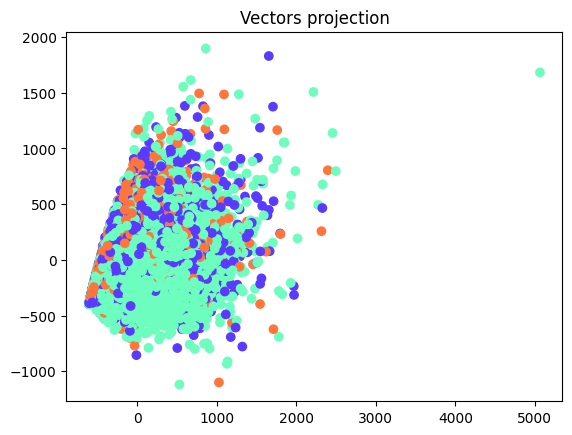

In [ ]:
pca = PCA(n_components=2, random_state=42)
d2 = pca.fit_transform(np.reshape(np.asarray([tensor.numpy() for tensor in x_train]), (len(x_train), 250)))
color_palette = sns.color_palette('rainbow', 12)

plt.scatter(
    d2[:, 0],
    d2[:, 1],
    c=[color_palette[int(x) * 5] for x in y_train])
plt.title('Vectors projection', fontsize=12)
plt.show()

На 2D графике классы предстают трудноразделимыми.

## Models

In [ ]:
callback = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
    )

In [ ]:
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
    )

### CNN

In [ ]:
model = tf.keras.Sequential()
model.add(layers.Embedding(vocab_size, 256, input_length=vectors_size))
model.add(layers.Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(layers.Dropout(.5))
model.add(layers.Conv1D(filters=16, kernel_size=6, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 250, 256)          128000    
                                                                 
 conv1d_35 (Conv1D)          (None, 248, 32)           24608     
                                                                 
 dropout_29 (Dropout)        (None, 248, 32)           0         
                                                                 
 conv1d_36 (Conv1D)          (None, 243, 16)           3088      
                                                                 
 global_max_pooling1d_16 (G  (None, 16)                0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_35 (Dense)            (None, 10)                170       
                                                     

In [ ]:
with tf.device('/gpu:0'):
  history = model.fit(
      np.reshape(np.asarray([tensor.numpy() for tensor in x_train]), (len(x_train), vectors_size)),
      y_train.to_numpy(),
      epochs=50,
      batch_size=64,
      validation_split=.2,
      callbacks=[callback],
      class_weight=dict(enumerate(weights))
      )

Epoch 1/50
1379/1379 [==============================] - 13s 9ms/step - loss: 0.9081 - accuracy: 0.6416 - val_loss: 0.7244 - val_accuracy: 0.7124
Epoch 2/50
1379/1379 [==============================] - 9s 6ms/step - loss: 0.8444 - accuracy: 0.6831 - val_loss: 0.7010 - val_accuracy: 0.7223
Epoch 3/50
1379/1379 [==============================] - 9s 6ms/step - loss: 0.8288 - accuracy: 0.6906 - val_loss: 0.6744 - val_accuracy: 0.7394
Epoch 4/50
1379/1379 [==============================] - 9s 6ms/step - loss: 0.8188 - accuracy: 0.6948 - val_loss: 0.6980 - val_accuracy: 0.7253
Epoch 5/50
1379/1379 [==============================] - 8s 6ms/step - loss: 0.8122 - accuracy: 0.6948 - val_loss: 0.7361 - val_accuracy: 0.7023
Epoch 6/50
1379/1379 [==============================] - 8s 6ms/step - loss: 0.8095 - accuracy: 0.6960 - val_loss: 0.6916 - val_accuracy: 0.7283
Epoch 7/50
1379/1379 [==============================] - 9s 7ms/step - loss: 0.8036 - accuracy: 0.6973 - val_loss: 0.6357 - val_accuracy

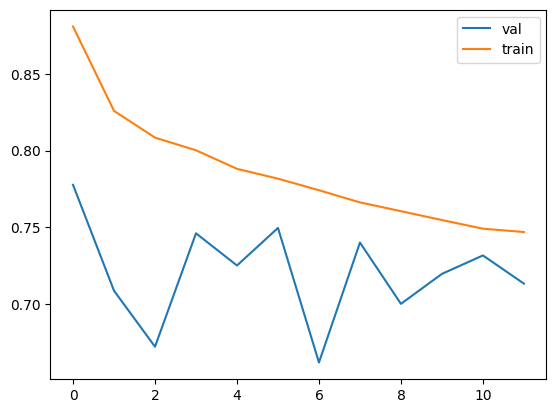

In [ ]:
plt.plot(history.history['val_loss'], label='val')
plt.plot(history.history['loss'], label='train')
plt.legend(loc='upper right')
plt.show()

In [ ]:
predicted = model.predict(np.reshape([tensor.numpy() for tensor in x_test], (x_test.shape[0], vectors_size)))
prediction = np.argmax(predicted, axis=1)
print(classification_report(y_test.to_numpy(), prediction))

1477/1477 [==============================] - 4s 3ms/step
              precision    recall  f1-score   support

           0       0.57      0.42      0.48      9043
           1       0.85      0.89      0.87     32607
           2       0.41      0.48      0.44      5606

    accuracy                           0.75     47256
   macro avg       0.61      0.59      0.60     47256
weighted avg       0.74      0.75      0.74     47256



Обучение CNN идёт плохо, не уверен, проблема с тем, что модель слишком сложная, или же с самими данными. Лосс функция остаётся большой как для валидации, так и для трейна.

### RNN

Собираю GRU, потому что LSTM, возможно, будет слишком сложной моделью для этой задачи, а SimpleRNN, как оказалось, не использует ГПУ.

In [ ]:
model = tf.keras.Sequential()
model.add(layers.Embedding(vocab_size, 100, input_length=vectors_size))
model.add(layers.GRU(128, return_sequences=False))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 250, 100)          50000     
                                                                 
 gru_4 (GRU)                 (None, 128)               88320     
                                                                 
 dropout_34 (Dropout)        (None, 128)               0         
                                                                 
 dense_40 (Dense)            (None, 3)                 387       
                                                                 
Total params: 138707 (541.82 KB)
Trainable params: 138707 (541.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
with tf.device('/gpu:0'):
  history = model.fit(
      np.reshape(np.asarray([tensor.numpy() for tensor in x_train]), (len(x_train), vectors_size)),
      y_train.to_numpy(),
      epochs=50,
      batch_size=64,
      validation_split=.2,
      callbacks=[callback],
      class_weight=dict(enumerate(weights))
      )

Epoch 1/50
1379/1379 [==============================] - 25s 17ms/step - loss: 0.9709 - accuracy: 0.5782 - val_loss: 0.8125 - val_accuracy: 0.6638
Epoch 2/50
1379/1379 [==============================] - 18s 13ms/step - loss: 0.8421 - accuracy: 0.6850 - val_loss: 0.7180 - val_accuracy: 0.7043
Epoch 3/50
1379/1379 [==============================] - 19s 13ms/step - loss: 0.7999 - accuracy: 0.6973 - val_loss: 0.7407 - val_accuracy: 0.6955
Epoch 4/50
1379/1379 [==============================] - 18s 13ms/step - loss: 0.7860 - accuracy: 0.7026 - val_loss: 0.7271 - val_accuracy: 0.6950
Epoch 5/50
1379/1379 [==============================] - 19s 14ms/step - loss: 0.7743 - accuracy: 0.7063 - val_loss: 0.7353 - val_accuracy: 0.6912
Epoch 6/50
1379/1379 [==============================] - 19s 14ms/step - loss: 0.7655 - accuracy: 0.7075 - val_loss: 0.6891 - val_accuracy: 0.7116
Epoch 7/50
1379/1379 [==============================] - 18s 13ms/step - loss: 0.7545 - accuracy: 0.7115 - val_loss: 0.7254 -

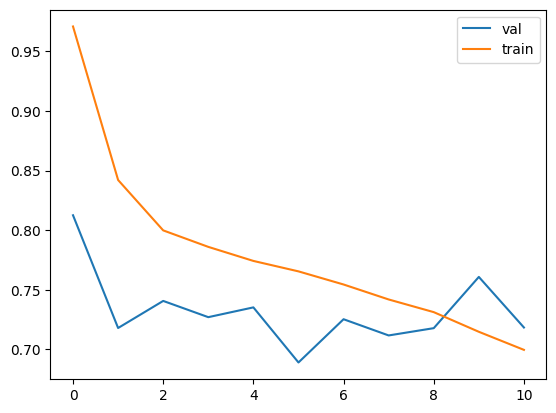

In [ ]:
plt.plot(history.history['val_loss'], label='val')
plt.plot(history.history['loss'], label='train')
plt.legend(loc='upper right')
plt.show()

In [ ]:
predicted = model.predict(np.reshape([tensor.numpy() for tensor in x_test], (x_test.shape[0], vectors_size)))
prediction = np.argmax(predicted, axis=1)
print(classification_report(y_test.to_numpy(), prediction))

1477/1477 [==============================] - 7s 4ms/step
              precision    recall  f1-score   support

           0       0.51      0.53      0.52      9043
           1       0.90      0.79      0.84     32607
           2       0.36      0.60      0.45      5606

    accuracy                           0.72     47256
   macro avg       0.59      0.64      0.60     47256
weighted avg       0.76      0.72      0.73     47256



Видно, что модель переобучается очень быстро. В целом, результаты на уровне с CNN, выше поднять не получилось

### Combined

In [ ]:
model = tf.keras.Sequential()
model.add(layers.Embedding(vocab_size, 100, input_length=vectors_size))
model.add(layers.Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(layers.MaxPooling1D())
model.add(layers.GRU(100, dropout=0.5))
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, 250, 100)          50000     
                                                                 
 conv1d_43 (Conv1D)          (None, 246, 128)          64128     
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 123, 128)          0         
 g1D)                                                            
                                                                 
 gru_11 (GRU)                (None, 100)               69000     
                                                                 
 dense_45 (Dense)            (None, 3)                 303       
                                                                 
Total params: 183431 (716.53 KB)
Trainable params: 183431 (716.53 KB)
Non-trainable params: 0 (0.00 Byte)
_____________

In [ ]:
with tf.device('/gpu:0'):
  history = model.fit(
      np.reshape(np.asarray([tensor.numpy() for tensor in x_train]), (len(x_train), vectors_size)),
      y_train.to_numpy(),
      epochs=50,
      batch_size=64,
      validation_split=.2,
      callbacks=[callback],
      class_weight=dict(enumerate(weights))
      )

Epoch 1/50
1379/1379 [==============================] - 23s 14ms/step - loss: 0.9121 - accuracy: 0.6320 - val_loss: 0.8260 - val_accuracy: 0.6538
Epoch 2/50
1379/1379 [==============================] - 16s 11ms/step - loss: 0.8127 - accuracy: 0.6948 - val_loss: 0.7411 - val_accuracy: 0.6923
Epoch 3/50
1379/1379 [==============================] - 16s 11ms/step - loss: 0.7883 - accuracy: 0.7023 - val_loss: 0.7558 - val_accuracy: 0.6888
Epoch 4/50
1379/1379 [==============================] - 15s 11ms/step - loss: 0.7749 - accuracy: 0.7071 - val_loss: 0.7479 - val_accuracy: 0.6898
Epoch 5/50
1379/1379 [==============================] - 17s 12ms/step - loss: 0.7617 - accuracy: 0.7104 - val_loss: 0.7575 - val_accuracy: 0.6778
Epoch 6/50
1379/1379 [==============================] - 15s 11ms/step - loss: 0.7508 - accuracy: 0.7142 - val_loss: 0.7727 - val_accuracy: 0.6739
Epoch 7/50
1379/1379 [==============================] - 16s 11ms/step - loss: 0.7374 - accuracy: 0.7178 - val_loss: 0.7351 -

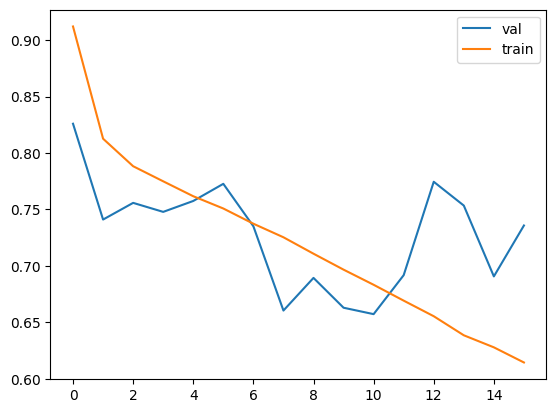

In [ ]:
plt.plot(history.history['val_loss'], label='val')
plt.plot(history.history['loss'], label='train')
plt.legend(loc='upper right')
plt.show()

In [ ]:
predicted = model.predict(np.reshape([tensor.numpy() for tensor in x_test], (x_test.shape[0], vectors_size)))
prediction = np.argmax(predicted, axis=1)
print(classification_report(y_test.to_numpy(), prediction))

1477/1477 [==============================] - 5s 3ms/step
              precision    recall  f1-score   support

           0       0.51      0.54      0.52      9043
           1       0.90      0.81      0.85     32607
           2       0.38      0.58      0.45      5606

    accuracy                           0.73     47256
   macro avg       0.60      0.64      0.61     47256
weighted avg       0.76      0.73      0.74     47256



Обучение данной модели, кажется, прошло получше, чем у разделённых моделек. Val loss продолжает колебаться, но я сомневаюсь, что он может упасть сильнее.

## Conclusion

Не особо понятно, что делать с переобучением: дропауты и уменьшение количества слоёв помогают, но результаты улучшаются не сильно. Возможно, проблема с векторами, не уверен, но это вероятно. Может, андерсэмплингом можно было бы добиться лучших результатов, но в этом я тоже сомневаюсь -- много данных пропадёт. По метрикам видно, что маленькие классы определяются значительно хуже, чем класс с рэпом.